In [4]:
import sympy

sympy.init_printing()

In [35]:
n_on, n_off, alpha, t_obs, t_ref, relative_flux = sympy.var([
    'N_\mathrm{on}',
    'N_\mathrm{off}',
    'alpha',
    't_\mathrm{obs}',
    't_\mathrm{ref}',
    '\phi_\mathrm{rel}',
])

In [36]:
n_on, n_off, alpha, t_obs, ratio

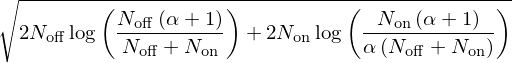

In [37]:
p_on = n_on / (n_on + n_off)
p_off = n_off / (n_on + n_off)

t1 = n_on * sympy.log(((1 + alpha) / alpha) * p_on)
t2 = n_off * sympy.log((1 + alpha) * p_off)

S_li_ma = sympy.sqrt(2 * (t1 + t2))

sympy.simplify(S_li_ma)

In [38]:
scale = t_ref / t_obs * relative_flux

scaled = sympy.simplify(S_li_ma.subs({n_on: n_on * scale, n_off: n_off * scale}))

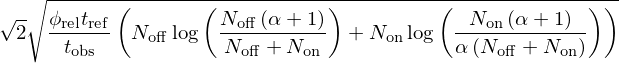

In [39]:
scaled

In [40]:
eq = sympy.Equality(scaled, 5)

In [ ]:
sympy.solve(eq, ratio)